In [1]:
# Install dependencies.
!pip install pywaffle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 34.5 MB/s eta 0:00:00


In [2]:
'''
This is a performance comparison between cold queries (without cache)
and warm queries (with cache) based on the Apache JMeter benchmark results.

The TPC-DS benchmark data for Dremio was generated according to this guide:
https://www.dremio.com/blog/dremio-benchmarking-methodology

Benchmark result files could be loaded from the project repo:
https://github.com/aabouzaid/modern-data-platform-poc/tree/main/benchmark
'''
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO as sio
from matplotlib.offsetbox import AnchoredText as obat
from pywaffle import Waffle

dataset_size = '10g'
dremio_version = '24.0.0'
plot_main_title = f'TPC-DS queries benchmark for Dremio v{dremio_version} - Dataset {dataset_size}'

In [3]:
# --------------- #
# Load
# --------------- #

# Inline data to make it self-contained Jupyter Notebook.
df_cold_csv = '''
timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
1678673745869,11001,q96,200,OK,Single Thread Group 1-1,text,true,,12,0,1,1,null,10999,0,985
1678673756871,15380,q7,200,OK,Single Thread Group 1-1,text,true,,4741,0,1,1,null,15373,0,0
1678673772253,4378,q19,200,OK,Single Thread Group 1-1,text,true,,5370,0,1,1,null,4374,0,0
1678673776630,6992,q25,200,OK,Single Thread Group 1-1,text,true,,437,0,1,1,null,6991,0,0
1678673783622,17084,q78,200,OK,Single Thread Group 1-1,text,true,,3806,0,1,1,null,17067,0,0
1678673800707,3777,q1,200,OK,Single Thread Group 1-1,text,true,,1714,0,1,1,null,3775,0,0
1678673804486,2554,q91,200,OK,Single Thread Group 1-1,text,true,,1276,0,1,1,null,2553,0,0
1678673807040,2477,q43,200,OK,Single Thread Group 1-1,text,true,,2548,0,1,1,null,2469,0,0
1678673809517,2204,q45,200,OK,Single Thread Group 1-1,text,true,,777,0,1,1,null,2203,0,0
1678673811721,4021,q33,200,OK,Single Thread Group 1-1,text,true,,1665,0,1,1,null,4021,0,0
1678673815743,3896,q46,200,OK,Single Thread Group 1-1,text,true,,5125,0,1,1,null,3892,0,0
1678673819639,2697,q62,200,OK,Single Thread Group 1-1,text,true,,4793,0,1,1,null,2696,0,1
1678673825186,3334,q63,200,OK,Single Thread Group 1-1,text,true,,3714,0,1,1,null,3316,0,0
1678673830259,3335,q60,200,OK,Single Thread Group 1-1,text,true,,2970,0,1,1,null,3335,0,0
1678673834790,3614,q85,200,OK,Single Thread Group 1-1,text,true,,433,0,1,1,null,3614,0,0
1678673838405,7138,q28,200,OK,Single Thread Group 1-1,text,true,,310,0,1,1,null,7137,0,0
1678673845543,2402,q81,200,OK,Single Thread Group 1-1,text,true,,13200,0,1,1,null,2373,0,0
1678673847945,4252,q97,200,OK,Single Thread Group 1-1,text,true,,62,0,1,1,null,4252,0,0
1678673852198,3694,q17,200,OK,Single Thread Group 1-1,text,true,,1146,0,1,1,null,3685,0,0
1678673857934,1841,q3,200,OK,Single Thread Group 1-1,text,true,,4490,0,1,1,null,1841,0,0
1678673864382,7494,q49,200,OK,Single Thread Group 1-1,text,true,,1629,0,1,1,null,7479,0,0
1678673871876,7842,q9,200,OK,Single Thread Group 1-1,text,true,,131,0,1,1,null,7801,0,0
1678673879720,4782,q31,200,OK,Single Thread Group 1-1,text,true,,26417,0,1,1,null,4773,0,0
1678673884504,11324,q11,200,OK,Single Thread Group 1-1,text,true,,5787,0,1,1,null,11323,0,0
1678673895827,5084,q93,200,OK,Single Thread Group 1-1,text,true,,965,0,1,1,null,5083,0,0
1678673900912,4714,q29,200,OK,Single Thread Group 1-1,text,true,,534,0,1,1,null,4706,0,0
1678673905627,2782,q89,200,OK,Single Thread Group 1-1,text,true,,8541,0,1,1,null,2780,0,0
1678673908410,1133,q15,200,OK,Single Thread Group 1-1,text,true,,2099,0,1,1,null,1133,0,0
1678673909543,1126,q52,200,OK,Single Thread Group 1-1,text,true,,4429,0,1,1,null,1125,0,0
1678673910671,3149,q50,200,OK,Single Thread Group 1-1,text,true,,4524,0,1,1,null,3148,0,0
1678673913822,1458,q42,200,OK,Single Thread Group 1-1,text,true,,369,0,1,1,null,1457,0,0
1678673915280,6143,q88,200,OK,Single Thread Group 1-1,text,true,,147,0,1,1,null,6142,0,0
1678673923365,3511,q71,200,OK,Single Thread Group 1-1,text,true,,372568,0,1,1,null,3286,0,0
1678673926875,2565,q34,200,OK,Single Thread Group 1-1,text,true,,36509,0,1,1,null,2564,0,0
1678673929440,1485,q30,200,OK,Single Thread Group 1-1,text,true,,10340,0,1,1,null,1474,0,0
1678673930925,1838,q73,200,OK,Single Thread Group 1-1,text,true,,408,0,1,1,null,1830,0,0
1678673932763,1149,q84,200,OK,Single Thread Group 1-1,text,true,,3236,0,1,1,null,1149,0,0
1678673933913,1025,q55,200,OK,Single Thread Group 1-1,text,true,,3977,0,1,1,null,1024,0,0
1678673934938,2723,q56,200,OK,Single Thread Group 1-1,text,true,,2367,0,1,1,null,2723,0,0
1678673938725,3090,q26,200,OK,Single Thread Group 1-1,text,true,,4153,0,1,1,null,3074,0,0
1678673941816,2496,q53,200,OK,Single Thread Group 1-1,text,true,,2650,0,1,1,null,2495,0,0
1678673944312,2301,q79,200,OK,Single Thread Group 1-1,text,true,,4235,0,1,1,null,2301,0,0
1678673946614,15477,q4,200,OK,Single Thread Group 1-1,text,true,,6005,0,1,1,null,15427,0,0
1678673962092,4346,q99,200,OK,Single Thread Group 1-1,text,true,,487,0,1,1,null,4345,0,0
1678673966438,3627,q68,200,OK,Single Thread Group 1-1,text,true,,7223,0,1,1,null,3625,0,0
1678673971396,3582,q76,200,OK,Single Thread Group 1-1,text,true,,6090,0,1,1,null,3581,0,0
'''

df_warm_csv = '''
timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
1678673976972,1865,q96,200,OK,Single Thread Group 1-1,text,true,,12,0,1,1,null,1863,0,864
1678673978839,5996,q7,200,OK,Single Thread Group 1-1,text,true,,4741,0,1,1,null,5987,0,0
1678673984834,2544,q19,200,OK,Single Thread Group 1-1,text,true,,5370,0,1,1,null,2536,0,0
1678673987379,2753,q25,200,OK,Single Thread Group 1-1,text,true,,437,0,1,1,null,2753,0,0
1678673990132,7632,q78,200,OK,Single Thread Group 1-1,text,true,,3806,0,1,1,null,7567,0,0
1678673997765,1850,q1,200,OK,Single Thread Group 1-1,text,true,,1714,0,1,1,null,1837,0,0
1678673999615,808,q91,200,OK,Single Thread Group 1-1,text,true,,1276,0,1,1,null,807,0,0
1678674000425,1534,q43,200,OK,Single Thread Group 1-1,text,true,,2548,0,1,1,null,1533,0,0
1678674001959,714,q45,200,OK,Single Thread Group 1-1,text,true,,777,0,1,1,null,713,0,0
1678674002674,2229,q33,200,OK,Single Thread Group 1-1,text,true,,1663,0,1,1,null,2228,0,0
1678674004903,3256,q46,200,OK,Single Thread Group 1-1,text,true,,5125,0,1,1,null,3253,0,0
1678674008161,1533,q62,200,OK,Single Thread Group 1-1,text,true,,4793,0,1,1,null,1531,0,0
1678674010118,3135,q63,200,OK,Single Thread Group 1-1,text,true,,3714,0,1,1,null,3134,0,0
1678674013682,2048,q60,200,OK,Single Thread Group 1-1,text,true,,2961,0,1,1,null,2048,0,1
1678674015911,1460,q85,200,OK,Single Thread Group 1-1,text,true,,433,0,1,1,null,1460,0,0
1678674017372,5377,q28,200,OK,Single Thread Group 1-1,text,true,,311,0,1,1,null,5367,0,0
1678674022748,1012,q81,200,OK,Single Thread Group 1-1,text,true,,13200,0,1,1,null,1009,0,0
1678674023760,3131,q97,200,OK,Single Thread Group 1-1,text,true,,62,0,1,1,null,3130,0,0
1678674026891,3203,q17,200,OK,Single Thread Group 1-1,text,true,,1146,0,1,1,null,3192,0,0
1678674030475,1641,q3,200,OK,Single Thread Group 1-1,text,true,,4537,0,1,1,null,1640,0,0
1678674034368,4921,q49,200,OK,Single Thread Group 1-1,text,true,,1629,0,1,1,null,4918,0,0
1678674039289,6141,q9,200,OK,Single Thread Group 1-1,text,true,,131,0,1,1,null,6140,0,0
1678674045431,3352,q31,200,OK,Single Thread Group 1-1,text,true,,26425,0,1,1,null,3349,0,0
1678674048783,8449,q11,200,OK,Single Thread Group 1-1,text,true,,5787,0,1,1,null,8423,0,0
1678674057231,4272,q93,200,OK,Single Thread Group 1-1,text,true,,965,0,1,1,null,4271,0,0
1678674061504,3284,q29,200,OK,Single Thread Group 1-1,text,true,,534,0,1,1,null,3283,0,1
1678674064788,2246,q89,200,OK,Single Thread Group 1-1,text,true,,8525,0,1,1,null,2245,0,0
1678674067034,570,q15,200,OK,Single Thread Group 1-1,text,true,,2099,0,1,1,null,561,0,0
1678674067604,1477,q52,200,OK,Single Thread Group 1-1,text,true,,4458,0,1,1,null,1476,0,0
1678674069082,2884,q50,200,OK,Single Thread Group 1-1,text,true,,4524,0,1,1,null,2883,0,0
1678674071967,904,q42,200,OK,Single Thread Group 1-1,text,true,,369,0,1,1,null,903,0,0
1678674072872,5939,q88,200,OK,Single Thread Group 1-1,text,true,,147,0,1,1,null,5939,0,0
1678674079142,2291,q71,200,OK,Single Thread Group 1-1,text,true,,372597,0,1,1,null,2065,0,0
1678674081433,1794,q34,200,OK,Single Thread Group 1-1,text,true,,36509,0,1,1,null,1791,0,0
1678674083228,1369,q30,200,OK,Single Thread Group 1-1,text,true,,10340,0,1,1,null,1364,0,0
1678674084597,1009,q73,200,OK,Single Thread Group 1-1,text,true,,408,0,1,1,null,1009,0,0
1678674085606,884,q84,200,OK,Single Thread Group 1-1,text,true,,3236,0,1,1,null,884,0,0
1678674086491,1053,q55,200,OK,Single Thread Group 1-1,text,true,,3933,0,1,1,null,1043,0,0
1678674087544,1813,q56,200,OK,Single Thread Group 1-1,text,true,,2367,0,1,1,null,1813,0,0
1678674089560,2095,q26,200,OK,Single Thread Group 1-1,text,true,,4153,0,1,1,null,2094,0,0
1678674091656,1409,q53,200,OK,Single Thread Group 1-1,text,true,,2650,0,1,1,null,1397,0,0
1678674093065,3460,q79,200,OK,Single Thread Group 1-1,text,true,,4235,0,1,1,null,3459,0,0
1678674096526,12427,q4,200,OK,Single Thread Group 1-1,text,true,,6005,0,1,1,null,12371,0,0
1678674108953,2900,q99,200,OK,Single Thread Group 1-1,text,true,,487,0,1,1,null,2900,0,0
1678674111853,3104,q68,200,OK,Single Thread Group 1-1,text,true,,7223,0,1,1,null,3103,0,0
1678674115290,2200,q76,200,OK,Single Thread Group 1-1,text,true,,6090,0,1,1,null,2190,0,0
'''

df_cold = pd.read_csv(sio(df_cold_csv), usecols=['timeStamp', 'elapsed', 'label'])
df_warm = pd.read_csv(sio(df_warm_csv), usecols=['timeStamp', 'elapsed', 'label'])

# Another way, is to load from files.
#df_cold = pd.read_csv(f'dremio-v{dremio_version}-tpc-ds-{dataset_size}-cold.csv', usecols=['timeStamp', 'elapsed', 'label'])
#df_warm = pd.read_csv(f'dremio-v{dremio_version}-tpc-ds-{dataset_size}-warm.csv', usecols=['timeStamp', 'elapsed', 'label'])

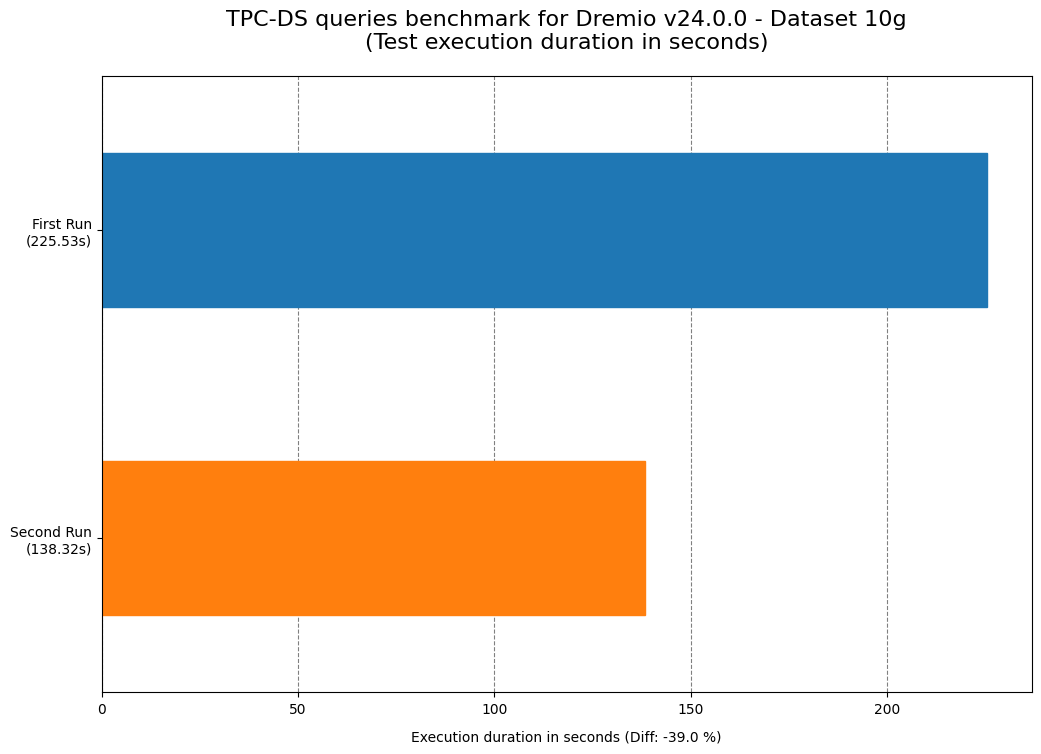

In [4]:
# Get details about the test execution duration.
exec_duration_cold_sec = ((df_cold['timeStamp'].iloc[-1] - df_cold['timeStamp'].iloc[0]) / 1000).round(2)
exec_duration_warm_sec = ((df_warm['timeStamp'].iloc[-1] - df_warm['timeStamp'].iloc[0]) / 1000).round(2)

# Create a dataframe for test execution duration.
exec_duration_df = pd.DataFrame({
    'exec': [
        f'First Run\n({exec_duration_cold_sec}s)',
        f'Second Run\n({exec_duration_warm_sec}s)'
    ],
    'duration_sec': [exec_duration_cold_sec, exec_duration_warm_sec]
})

# Calculate percentage differences between the first and the second run.
exec_duration_diff_pct = exec_duration_df[['duration_sec']].pct_change()['duration_sec'].iloc[1].round(2) * 100

#-------------------------#
# Plot execution duration #
#-------------------------#

exec_duration = exec_duration_df.plot.barh(x='exec', y='duration_sec', legend=False, figsize=(12, 8))
exec_duration.invert_yaxis()
exec_duration.set_title(f'{plot_main_title}\n(Test execution duration in seconds)', pad=20, size=16)
exec_duration.set_xlabel(f'Execution duration in seconds (Diff: {exec_duration_diff_pct} %)', labelpad=10)
exec_duration.set_ylabel('')
exec_duration.xaxis.grid(color='gray', linestyle='dashed')
exec_duration.set_axisbelow(True)
for color, bar in zip(['tab:blue', 'tab:orange'], exec_duration.patches):
    bar.set_color(color)

In [5]:
# --------------- #
# Prepare
# --------------- #

# Merge cold and warm benchmark results in one dataframe.
df_combined = df_cold.merge(df_warm, on='label', how='left', suffixes=('_cold', '_warm'))

# Calculate percentage enhancement between cold and warm results.
df_combined['elapsed_diff_pct'] = ((df_combined[['elapsed_cold', 'elapsed_warm']].pct_change(axis=1)['elapsed_warm']) * 100).round(2)

# Create a new dataframe with elapsed time in seconds (JMeter's elapsed time unit is in milliseconds).
df_cleaned = pd.DataFrame({
        'duration_cold_sec': df_combined['elapsed_cold'].apply(lambda x: x / 1000).tolist(),
        'duration_warm_sec': df_combined['elapsed_warm'].apply(lambda x: x / 1000).tolist(),
        'duration_diff_pct': df_combined['elapsed_diff_pct'].tolist(),
    },
    index=df_combined['label']
)

In [6]:
print(df_cleaned.sample(5).to_csv(sep="\t"))

label	duration_cold_sec	duration_warm_sec	duration_diff_pct
q25	6.992	2.753	-60.63
q33	4.021	2.229	-44.57
q62	2.697	1.533	-43.16
q73	1.838	1.009	-45.1
q28	7.138	5.377	-24.67



In [7]:
# --------------- #
# Plot
# --------------- #

plt.rcParams.update({
    # Set background for all plots.
    "figure.facecolor": 'white'
})

Text(0.5, 0.98, 'TPC-DS queries benchmark for Dremio v24.0.0 - Dataset 10g\n(Status of the TPC-DS 99 queries)')

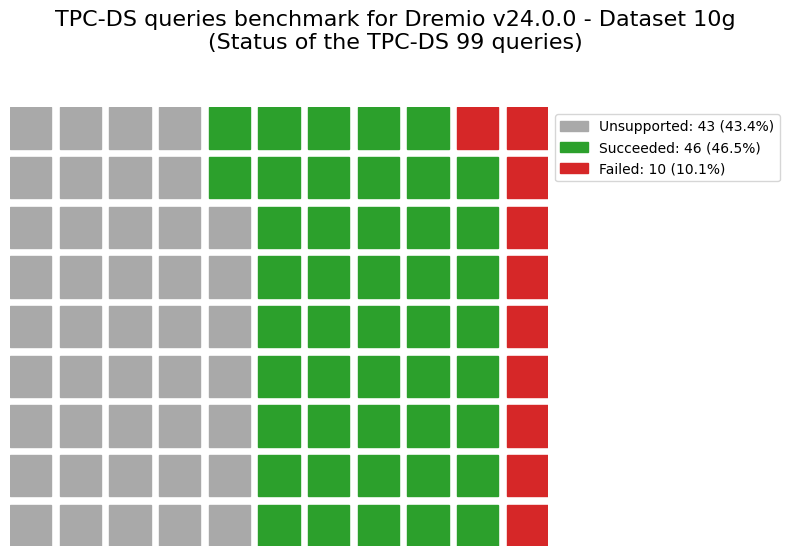

In [8]:
#--------------------------#
# Plot TPC-DS tests status #
#--------------------------#

tpcds_tests_data = {'Unsupported': 43, 'Succeeded': 46, 'Failed': 10}
tpcds_tests_labels = [f"{k}: {v} ({v / 99 * 100:.1f}%)" for k, v in tpcds_tests_data.items()]

tpcds_tests = plt.figure(
    FigureClass=Waffle,
    figsize=(8, 6),
    rows=9,
    columns=11,
    values=tpcds_tests_data,
    labels=tpcds_tests_labels,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=["darkgray", 'tab:green', 'tab:red'],
)

tpcds_tests.suptitle(f'{plot_main_title}\n(Status of the TPC-DS 99 queries)', fontsize=16)

Text(0, 0.5, '')

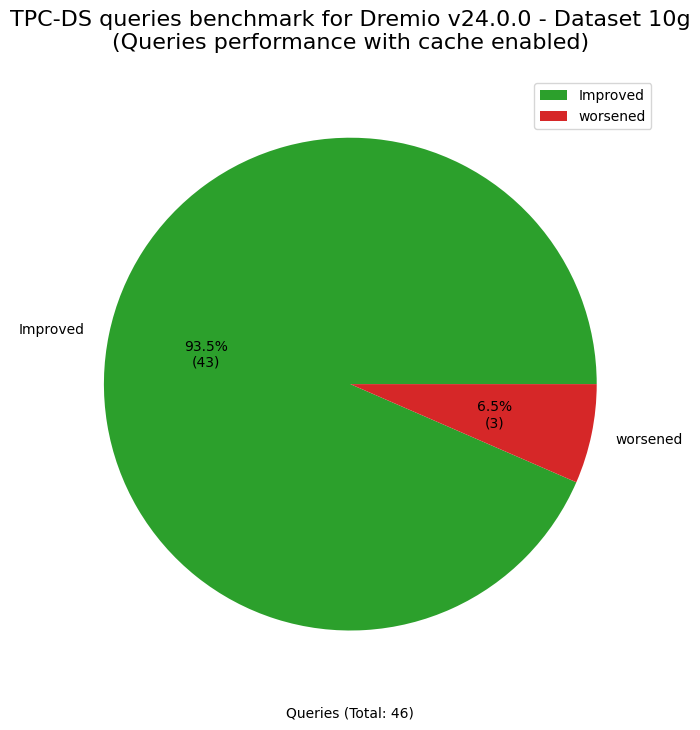

In [9]:
#---------------------------------------------#
# Plot queries performance with cache enabled #
#---------------------------------------------#

query_performance_df = pd.DataFrame({
        'queries': [len(df_cleaned[df_cleaned['duration_diff_pct'] < 0]),
                  len(df_cleaned[df_cleaned['duration_diff_pct'] > 0])],
    },
    index=['Improved', 'worsened']
)

# Show the percentage and actual value at the same time.
def autopct_format(pct):
    total = sum(query_performance_df['queries'])
    return '{:.1f}%\n({:.0f})'.format(pct, total * pct / 100)

query_performance = query_performance_df.plot.pie(y='queries', colors=['tab:green', 'tab:red'], autopct=autopct_format, figsize=(12, 8))
query_performance.set_title(f'{plot_main_title}\n(Queries performance with cache enabled)', pad=20, size=16)
query_performance.set_xlabel(f'Queries (Total: {query_performance_df["queries"].sum()})', labelpad=10)
query_performance.set_ylabel('')

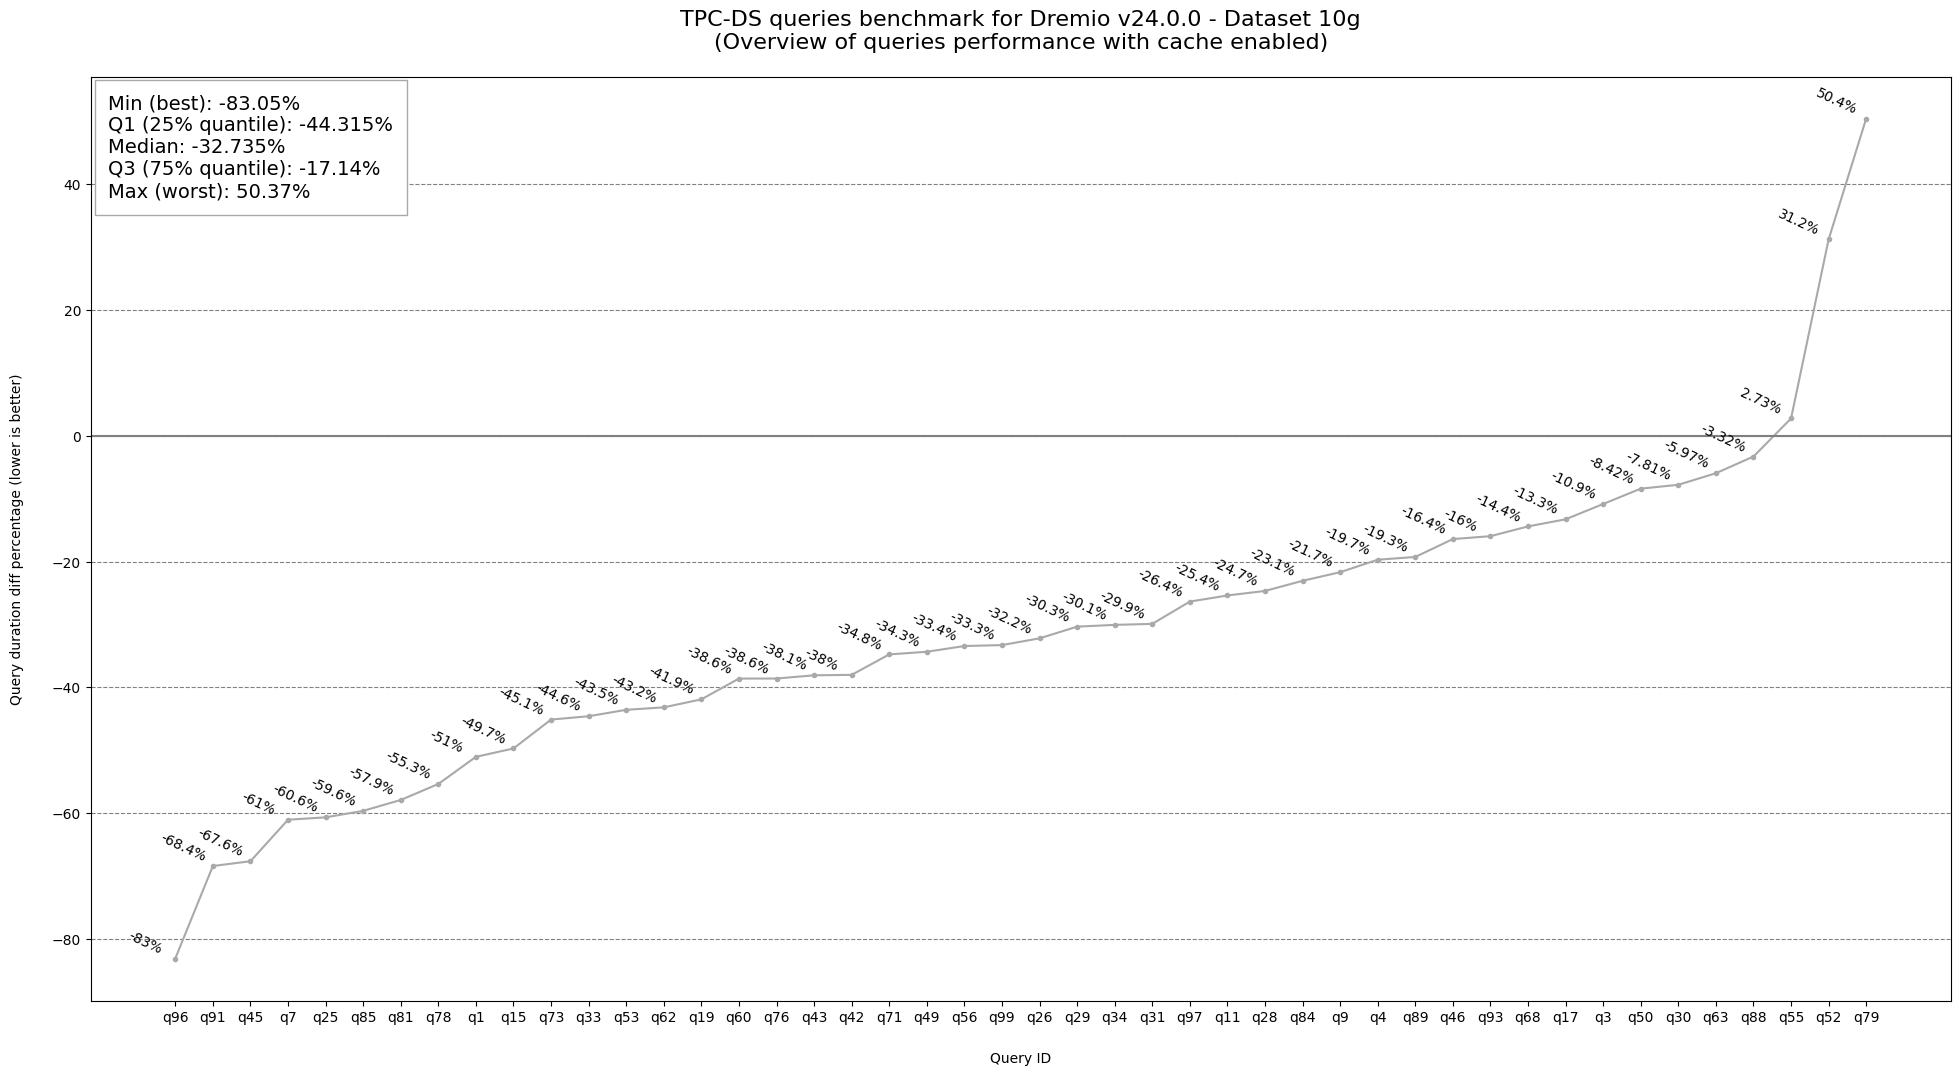

In [10]:
#-------------------------------------------------------------#
# Plot overview of the queries performance with cache enabled #
#-------------------------------------------------------------#

diff_pct_df = df_cleaned.sort_values(by=['duration_diff_pct'])['duration_diff_pct']
diff_pct = diff_pct_df.plot.line(color='darkgray', style='.-', rot=0, figsize=(24, 12))
diff_pct.yaxis.grid(color='gray', linestyle='dashed')
diff_pct.set_axisbelow(True)
diff_pct.set_title(f'{plot_main_title}\n(Overview of queries performance with cache enabled)', pad=20, size=16)
diff_pct.set_xlabel('Query ID', labelpad=20)
diff_pct.set_ylabel('Query duration diff percentage (lower is better)', labelpad=20)
xticks = range(diff_pct_df.count())
diff_pct.set_xticks(xticks)
diff_pct.set_xticklabels(diff_pct_df.index.tolist())
diff_pct.axhline(0, color='gray')
for index in xticks:
    diff_pct.text(index-0.8, diff_pct_df[index]+0.8, '{0:.3g}%'.format(diff_pct_df[index]), horizontalalignment='center', rotation=-25)

# Add summary box.
diff_pct_stat = (
    f'Min (best): {diff_pct_df.min()}%\n'
    f'Q1 (25% quantile): {diff_pct_df.quantile(0.25)}%\n'
    f'Median: {diff_pct_df.median()}%\n'
    f'Q3 (75% quantile): {diff_pct_df.quantile(0.75)}%\n'
    f'Max (worst): {diff_pct_df.max()}%'
)
diff_pct_details = obat(diff_pct_stat, prop=dict(size=14), frameon=True, loc='upper left')
diff_pct_details.patch.set(boxstyle='square', edgecolor='darkgray')
diff_pct.add_artist(diff_pct_details)

Text(0, 0.5, '')

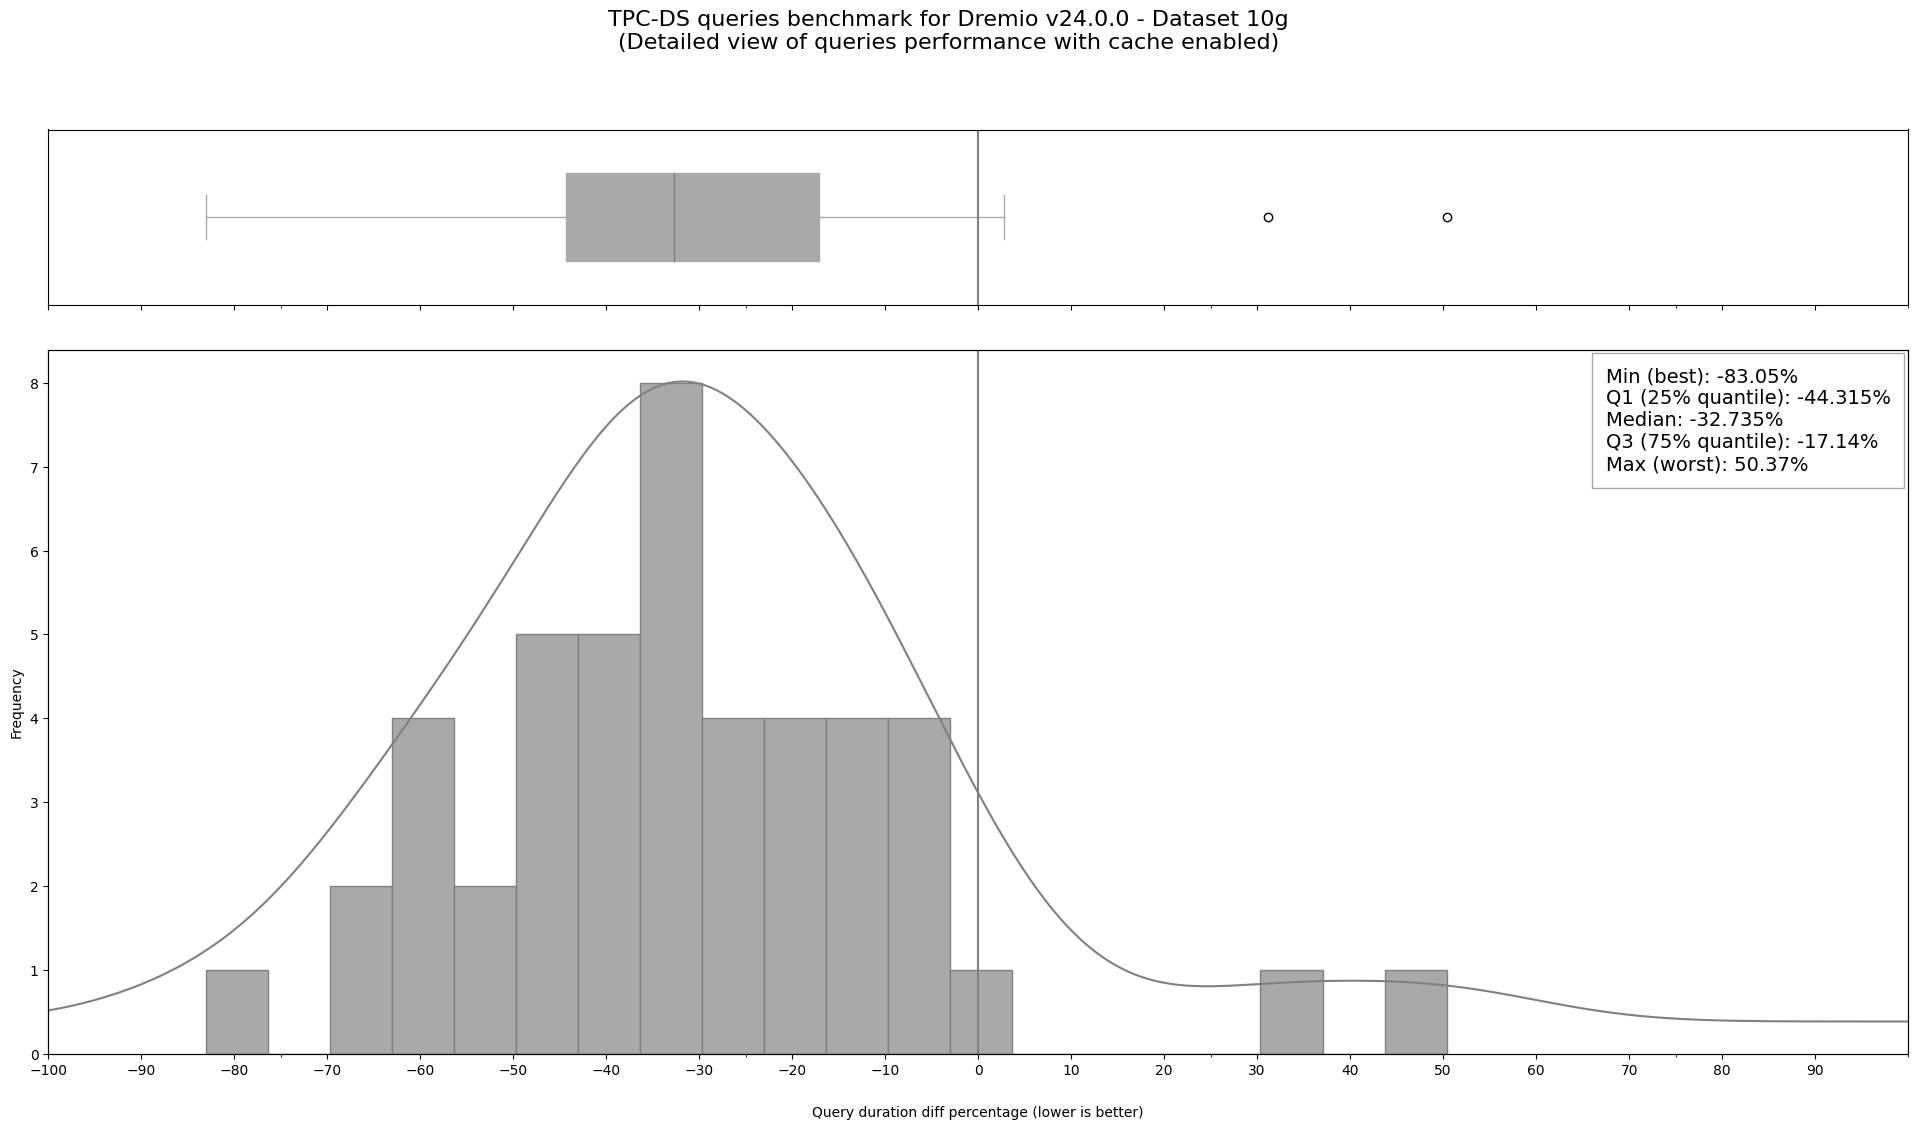

In [11]:
#---------------------------------------#
# Plot queries performance distribution #
#---------------------------------------#

# Base.
fig, ax = plt.subplots(2, figsize=(24, 12), sharex=True, gridspec_kw={"height_ratios": (.2, .8)})
fig.suptitle(f'{plot_main_title}\n(Detailed view of queries performance with cache enabled)', size=16)
plt.subplots_adjust(hspace=0.1)

# Summary.
diff_pct_details = obat(diff_pct_stat, prop=dict(size=14), frameon=True, loc='upper right')
diff_pct_details.patch.set(boxstyle='square', edgecolor='darkgray')
ax[1].add_artist(diff_pct_details)

# Boxplot.
diff_pct_box = diff_pct_df.plot.box(color='darkgray', vert=False, medianprops={'color': 'gray'}, patch_artist=True, widths = 0.5, ax=ax[0])
diff_pct_box.axvline(0, color='gray')
diff_pct_box.set_yticks([])

# Histogram.
diff_pct_hist = diff_pct_df.plot.hist(color='darkgray', edgecolor='gray', bins=20, xlim=[-100, 100], ax=ax[1])
diff_pct_hist.set_xticks(range(-100, 100, 10))
diff_pct_hist.axvline(0, color='gray')
diff_pct_hist.set_xlabel('Query duration diff percentage (lower is better)', labelpad=20)

# Distribution line.
diff_pct_kde = diff_pct_df.plot.kde(color='gray', ax=diff_pct_hist.twinx())
diff_pct_kde.set_yticks([])
diff_pct_kde.set_ylabel('')

In [12]:
# Set labels with percentage enhancement to make it easy to plot bars.
df_cleaned['label_diff_pct'] = df_cleaned.assign(label=df_cleaned.index)[['label', 'duration_diff_pct']].apply(
    lambda x : f'{x[0]} (diff: {x[1]}%)', axis=1)
df_cleaned.head()

,duration_cold_sec,duration_warm_sec,duration_diff_pct,label_diff_pct
label,,,,
q96,11.001,1.865,-83.05,q96 (diff: -83.05%)
q7,15.380,5.996,-61.01,q7 (diff: -61.01%)
q19,4.378,2.544,-41.89,q19 (diff: -41.89%)
q25,6.992,2.753,-60.63,q25 (diff: -60.63%)
q78,17.084,7.632,-55.33,q78 (diff: -55.33%)


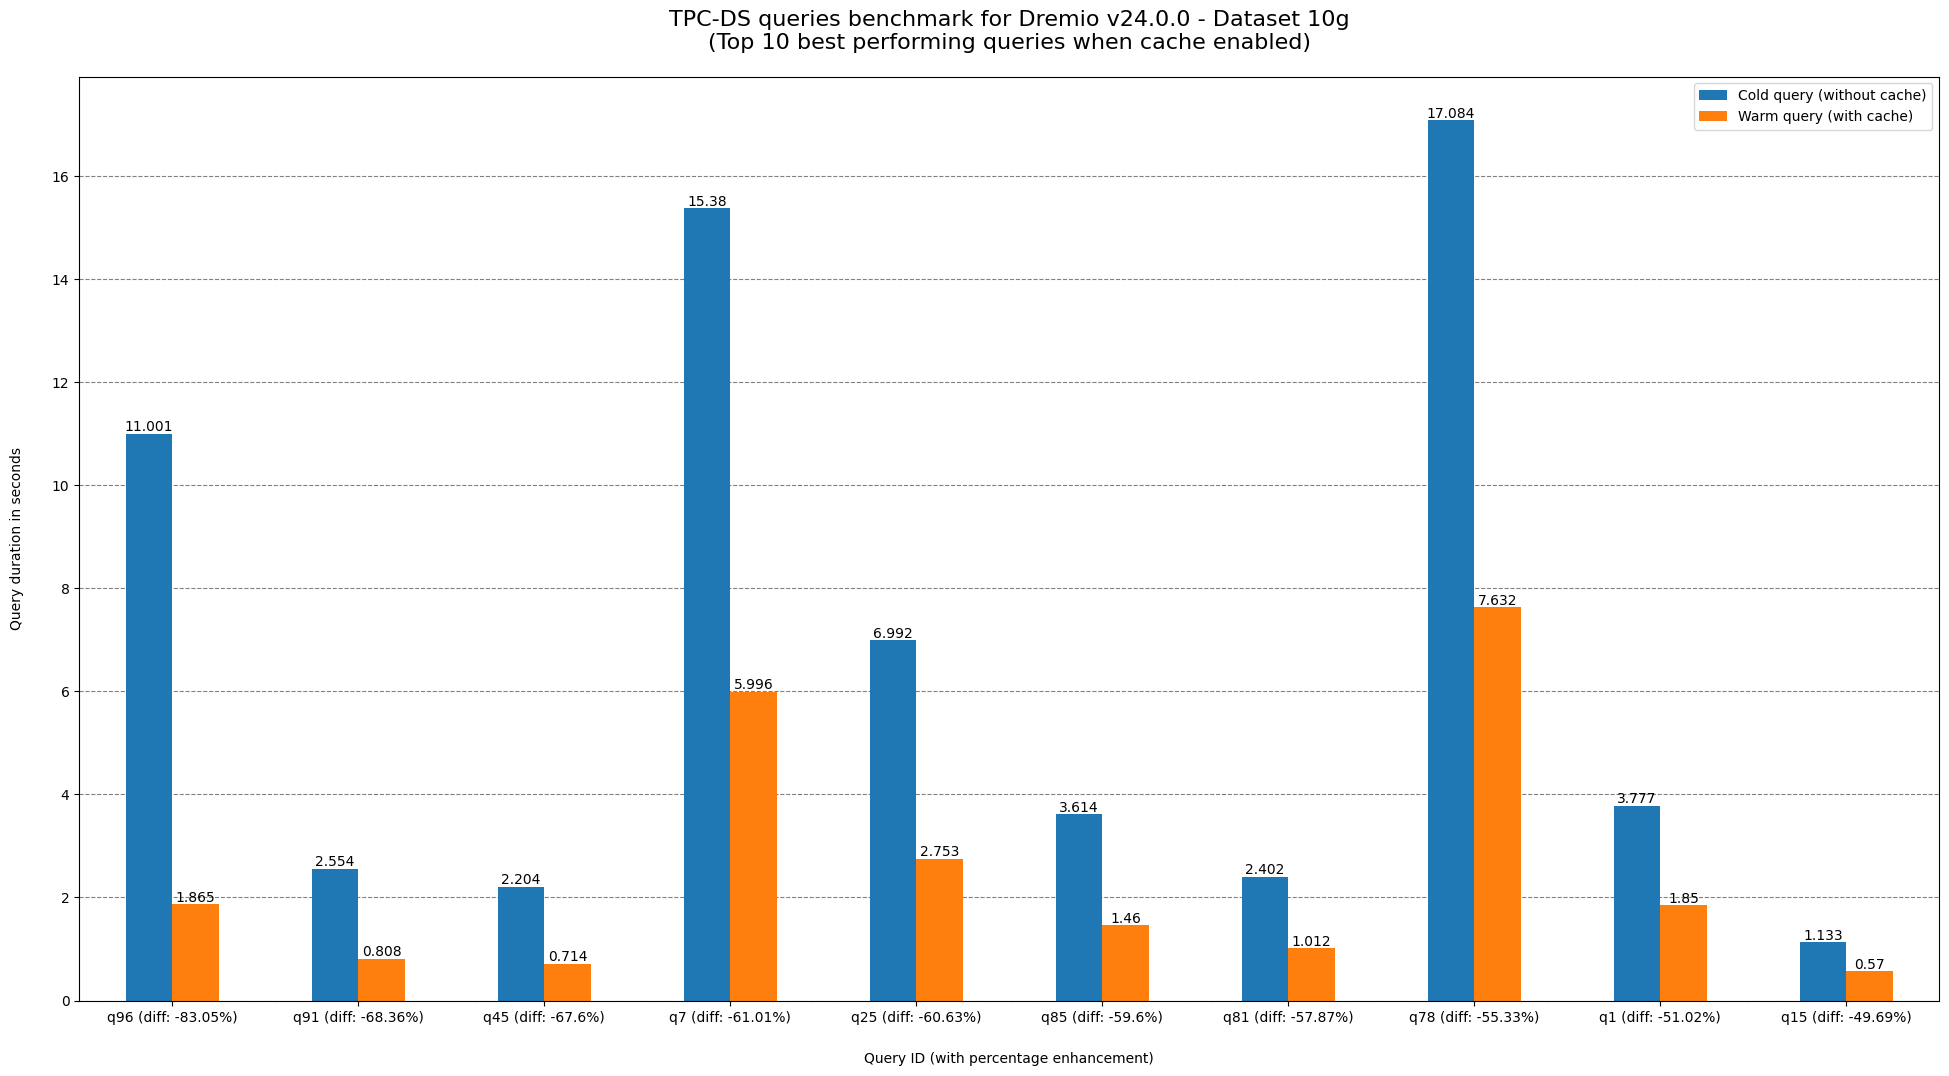

In [13]:
#-----------------------------------------#
# Plot the best 10 queries by using cache #
#-----------------------------------------#

best_queries_df = df_cleaned.nsmallest(10, 'duration_diff_pct')
best_queries = best_queries_df.plot.bar(y=['duration_cold_sec', 'duration_warm_sec'], x='label_diff_pct', rot=0, figsize=(24, 12))
best_queries.legend(["Cold query (without cache)", "Warm query (with cache)"])
best_queries.yaxis.grid(color='gray', linestyle='dashed')
best_queries.set_axisbelow(True)
best_queries.set_title(f'{plot_main_title}\n(Top 10 best performing queries when cache enabled)', pad=20, size=16)
best_queries.set_xlabel('Query ID (with percentage enhancement)', labelpad=20)
best_queries.set_ylabel('Query duration in seconds', labelpad=20)
for container in best_queries.containers:
    best_queries.bar_label(container)

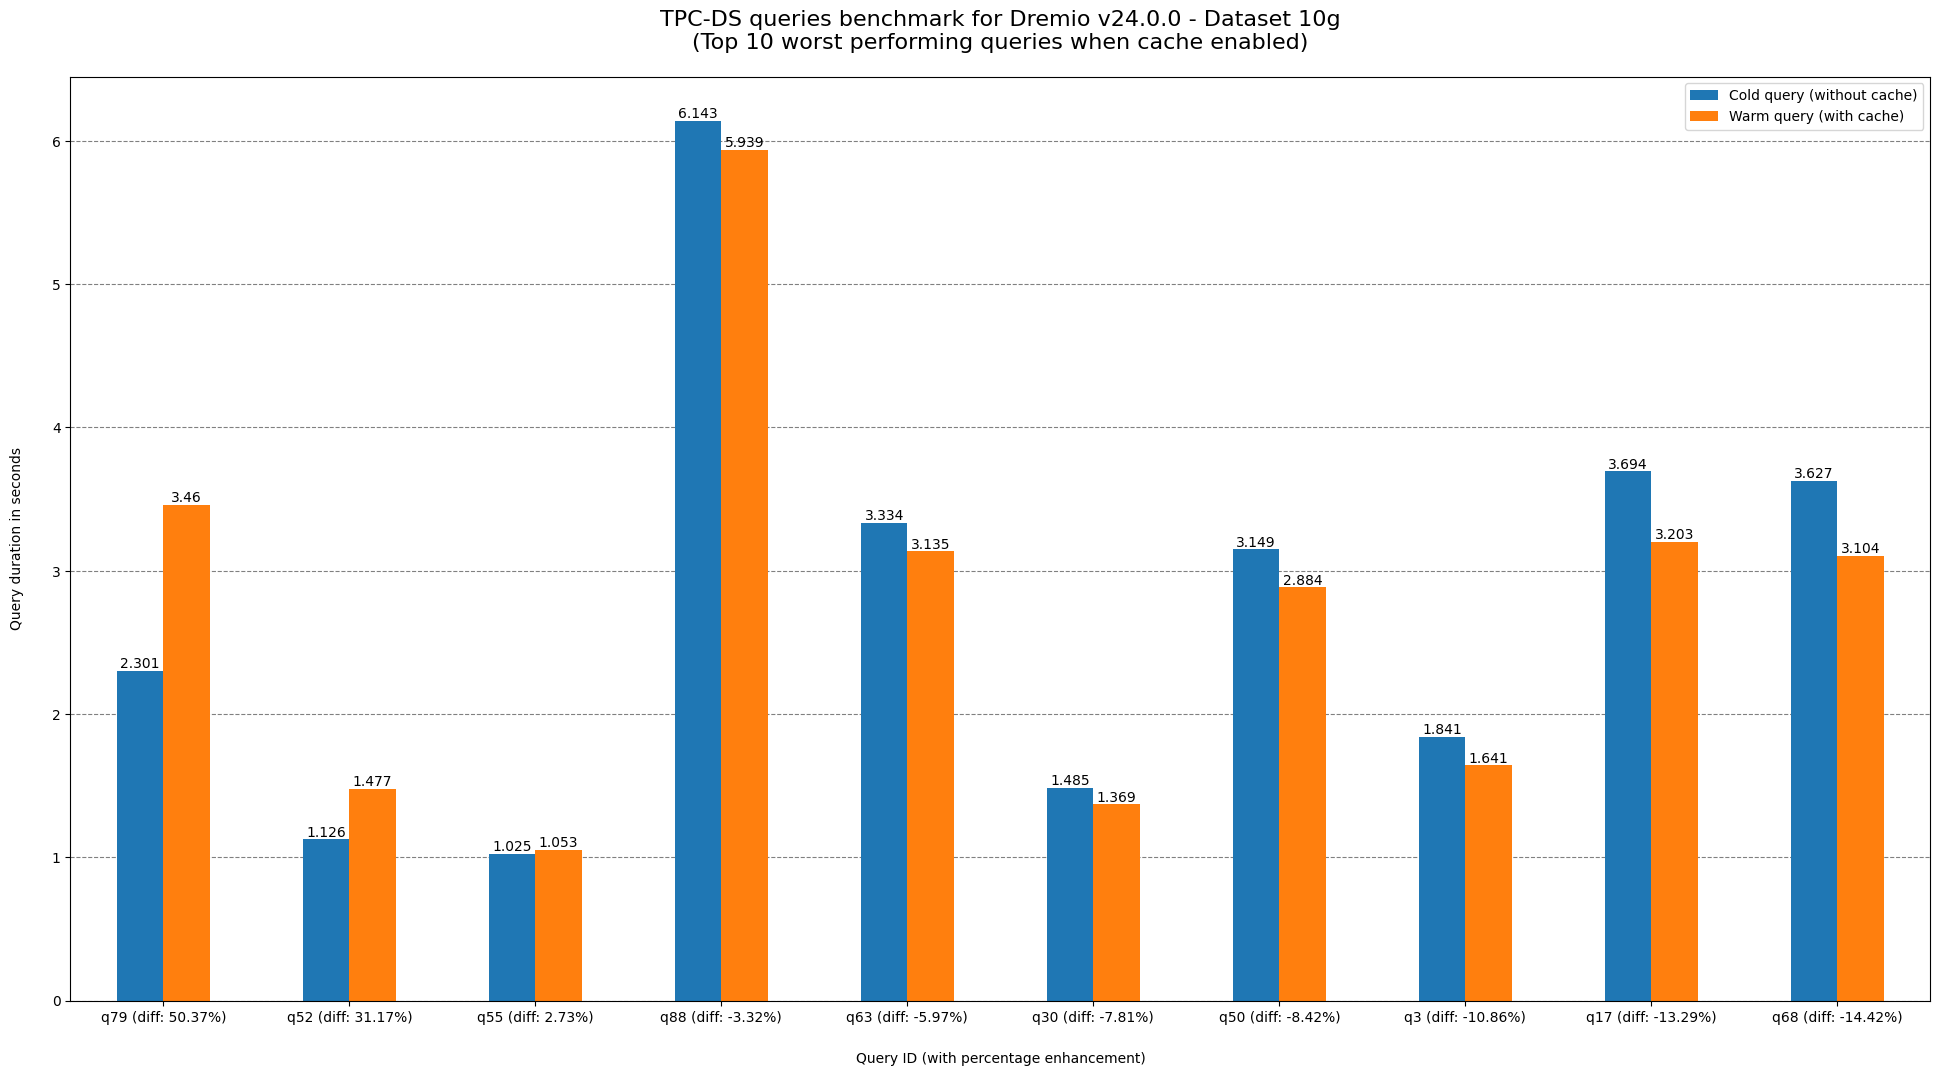

In [14]:
#------------------------------------------#
# Plot the worst 10 queries by using cache #
#------------------------------------------#

worst_queries_df = df_cleaned.nlargest(10, 'duration_diff_pct')
worst_queries = worst_queries_df.plot.bar(y=['duration_cold_sec', 'duration_warm_sec'], x='label_diff_pct', rot=0, figsize=(24, 12))
worst_queries.legend(["Cold query (without cache)", "Warm query (with cache)"])
worst_queries.yaxis.grid(color='gray', linestyle='dashed')
worst_queries.set_axisbelow(True)
worst_queries.set_title(f'{plot_main_title}\n(Top 10 worst performing queries when cache enabled)', pad=20, size=16)
worst_queries.set_xlabel('Query ID (with percentage enhancement)', labelpad=20)
worst_queries.set_ylabel('Query duration in seconds', labelpad=20)
for container in worst_queries.containers:
    worst_queries.bar_label(container)